In [58]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

In [2]:
data_x = pd.read_csv('/kaggle/input/songs-prediction-2025/train_x.csv')
data_y = pd.read_csv('/kaggle/input/songs-prediction-2025/train_y.csv')

In [3]:
data_x.rename(columns={'Unnamed: 0': 'key'}, inplace=True)
data_y.rename(columns={'Unnamed: 0': 'key'}, inplace=True)

In [4]:
train_data = pd.merge(data_x, data_y, how='left', on=['key'])
train_data.head()

,key,0,1,2,3,4,5,6,7,8,...,81,82,83,84,85,86,87,88,89,year
0,133081,37.47518,-14.34414,40.54872,-9.10171,16.77175,-17.77113,-16.50156,-4.09543,2.49723,...,-115.62803,-13.79660,31.60436,28.95927,-25.93164,67.64670,-25.76691,-81.90373,-61.48682,2001
1,111484,48.17393,-7.02208,-30.36086,-2.41924,2.15406,-8.44502,-1.68191,-8.71434,-7.83802,...,24.58950,-36.95682,0.73922,-0.06330,53.75838,-81.05330,8.42811,12.08694,-1.91676,2006
2,448402,36.58141,26.03203,-4.92774,35.71620,8.53080,3.73167,-7.98443,-7.43976,-1.69797,...,-366.07968,-62.38201,113.48188,4.72741,181.64459,-134.46216,8.50795,94.15573,-8.47276,1989
3,254414,41.15615,-17.77029,-32.30961,-21.03778,12.80330,-13.48031,-3.14951,-7.62647,-4.48901,...,-79.64532,-77.08169,38.88094,28.52025,24.17783,-86.62542,-1.19418,-74.73449,-17.28130,1997
4,272580,40.54855,78.77563,-23.29877,98.60192,-30.11496,26.94220,-8.87771,-3.23280,-1.04841,...,-252.61021,118.93768,-155.87390,51.85666,-365.15815,59.34936,52.47311,99.00695,-10.18840,2001


In [5]:
X = train_data.drop(columns=['key', 'year'])
y = train_data['year']

In [6]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_scaled, y, test_size=0.3, random_state=42)

In [8]:
class MyDataset(Dataset):
    def __init__(self, X, y, min_year=1922):
        self.X = X
        self.y = y - min_year
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y.iloc[idx], dtype=torch.float32).unsqueeze(0)
        return X, y

In [90]:
batch_size = 64

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for X, y in train_dataloader:
    print(f"Shape of X: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X: torch.Size([64, 90])
Shape of y: torch.Size([64, 1]) torch.float32


In [143]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
n_classes = 2011 - 1922 + 1

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(90, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.5),


            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Dropout(0.5),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.GELU(),
            nn.Dropout(0.5),

            nn.Linear(64, 32),
            nn.GELU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=90, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): GELU(approximate='none')
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=256, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): GELU(approximate='none')
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=128, out_fe

In [144]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [145]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Предсказание и ошибка
        pred = model(X)
        loss = loss_fn(pred, y)

        # Обратное распространение
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X.size(0)

        # Каждые 100 батчей выводим статистику
        if batch % 100 == 0:
            current = (batch + 1) * len(X)
            print(f"loss: {loss.item():>7f}  [{current:>5d}/{size:>5d}]")

    avg_loss = total_loss / size
    print(f"Train Avg MSE: {avg_loss:.6f}")
    return avg_loss

In [146]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, mae_sum = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item() * X.size(0)
            mae_sum += (pred - y).abs().sum().item()

    # Средние метрики
    avg_mse = test_loss / size
    avg_rmse = avg_mse ** 0.5
    avg_mae = mae_sum / size

    print(f"Test Results:\n MSE: {avg_mse:.4f}, RMSE: {avg_rmse:.4f}, MAE: {avg_mae:.4f}\n")
    return avg_mse, avg_rmse, avg_mae

In [147]:
# Списки для хранения метрик по эпохам
train_mses = []
test_mses = []

epochs = 70
best_test_mse = float('inf')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    
    # Train
    max_epoch = t
    train_mse = train(train_dataloader, model, loss_fn, optimizer)
    train_mses.append(train_mse)
    
    # Test
    test_mse, test_rmse, test_mae = test(test_dataloader, model, loss_fn)
    test_mses.append(test_mse)

    if test_mse < best_test_mse:
        best_test_mse = test_mse
        best_model_state = model.state_dict().copy()
        print(f"✅ New best model saved at epoch {t+1}, Val MSE={test_mse:.4f}")    

model.load_state_dict(best_model_state)
torch.save(model.state_dict(), "best_model.pth")
print("Training Done!")

Epoch 1
-------------------------------
loss: 5987.940918  [   64/ 9800]
loss: 4472.672852  [ 6464/ 9800]
Train Avg MSE: 4642.421445
Test Results:
 MSE: 3571.9069, RMSE: 59.7654, MAE: 58.8055

✅ New best model saved at epoch 1, Val MSE=3571.9069
Epoch 2
-------------------------------
loss: 2112.203613  [   64/ 9800]
loss: 352.476288  [ 6464/ 9800]
Train Avg MSE: 691.570658
Test Results:
 MSE: 752.3830, RMSE: 27.4296, MAE: 25.6289

✅ New best model saved at epoch 2, Val MSE=752.3830
Epoch 3
-------------------------------
loss: 430.202942  [   64/ 9800]
loss: 353.576233  [ 6464/ 9800]
Train Avg MSE: 332.087394
Test Results:
 MSE: 442.0301, RMSE: 21.0245, MAE: 19.2868

✅ New best model saved at epoch 3, Val MSE=442.0301
Epoch 4
-------------------------------
loss: 352.444702  [   64/ 9800]
loss: 264.477142  [ 6464/ 9800]
Train Avg MSE: 301.326121
Test Results:
 MSE: 272.1445, RMSE: 16.4968, MAE: 14.5369

✅ New best model saved at epoch 4, Val MSE=272.1445
Epoch 5
----------------------

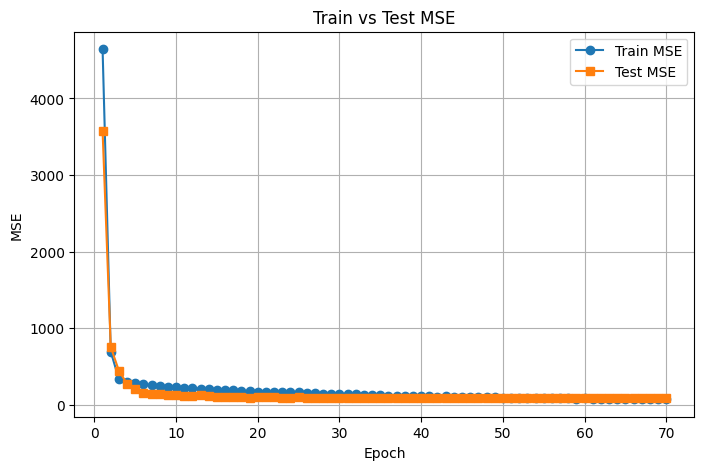

In [148]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs + 1), train_mses, label='Train MSE', marker='o')
plt.plot(range(1, epochs + 1), test_mses, label='Test MSE', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Train vs Test MSE')
plt.grid(True)
plt.legend()
plt.show()

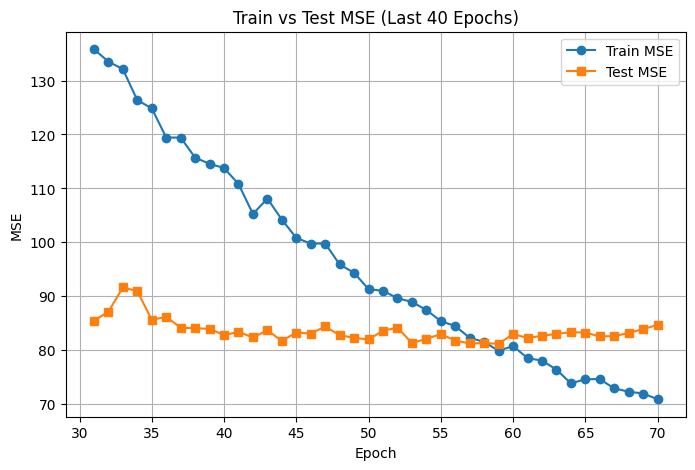

In [149]:
n_last = 40


train_last = train_mses[-n_last:]
test_last = test_mses[-n_last:]
epochs_last = range(len(train_mses)-n_last+1, len(train_mses)+1)

plt.figure(figsize=(8,5))
plt.plot(epochs_last, train_last, label='Train MSE', marker='o')
plt.plot(epochs_last, test_last, label='Test MSE', marker='s')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(f'Train vs Test MSE (Last {n_last} Epochs)')
plt.grid(True)
plt.legend()
plt.show()

In [151]:
full_dataset = ConcatDataset([train_dataset, test_dataset])
full_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = NeuralNetwork().to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

epochs = 59
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_mse = train(full_dataloader, model, loss_fn, optimizer)

print("Training Done!")

Epoch 1
-------------------------------
loss: 5807.425293  [   64/ 4200]
Train Avg MSE: 5668.285474
Epoch 2
-------------------------------
loss: 4885.103516  [   64/ 4200]
Train Avg MSE: 4063.707047
Epoch 3
-------------------------------
loss: 2838.730225  [   64/ 4200]
Train Avg MSE: 1489.864100
Epoch 4
-------------------------------
loss: 579.692749  [   64/ 4200]
Train Avg MSE: 422.796728
Epoch 5
-------------------------------
loss: 252.060303  [   64/ 4200]
Train Avg MSE: 347.075650
Epoch 6
-------------------------------
loss: 338.666260  [   64/ 4200]
Train Avg MSE: 342.820024
Epoch 7
-------------------------------
loss: 264.532654  [   64/ 4200]
Train Avg MSE: 324.232038
Epoch 8
-------------------------------
loss: 237.168671  [   64/ 4200]
Train Avg MSE: 312.954393
Epoch 9
-------------------------------
loss: 298.574219  [   64/ 4200]
Train Avg MSE: 292.905557
Epoch 10
-------------------------------
loss: 273.662323  [   64/ 4200]
Train Avg MSE: 292.182039
Epoch 11
----

In [152]:
test_data = pd.read_csv('/kaggle/input/songs-prediction-2025/test_x.csv')
test_data.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,id
0,44.69970,7.96998,-15.16859,-15.88686,1.58073,-6.23497,-11.59792,-11.71405,4.32023,-8.56689,...,16.70871,22.73881,12.92728,5.35942,33.01436,-54.54467,-2.53457,19.44396,8.74708,3416
1,50.75305,49.55872,30.33403,-13.05537,-34.51915,-21.38223,1.07836,-7.79340,15.95731,8.97746,...,56.64278,-58.77229,44.02523,-6.08207,127.27562,53.55449,-21.83976,-46.89782,-12.17533,18991
2,39.41930,-38.69590,-22.15177,-4.07812,-19.06480,-11.15927,14.99402,2.75120,2.32396,4.29177,...,-90.24540,-123.84976,65.31781,8.30738,-148.93180,-162.58971,-6.31094,-116.44189,-7.85765,11105
3,46.67711,56.98689,-22.63047,-10.90758,4.69374,15.66760,-7.25281,13.54849,-1.37275,16.10065,...,-257.63385,32.63454,-117.37477,3.12995,61.86812,-246.54612,2.13762,27.88064,-13.57062,18902
4,40.14486,-20.88083,-7.30665,-1.21121,27.23754,-22.98837,-1.81173,-2.44144,0.06913,-3.55877,...,262.05281,190.80106,224.96182,8.19406,-44.09140,-14.54322,-7.52484,-57.88128,0.91497,18958


In [153]:
ids = test_data['id']
test_data.drop(columns=['id'], inplace=True)

In [154]:
X_test_scaled = scaler.transform(test_data)
X_test_scaled

array([[ 0.21486141,  0.12466205, -0.65881343, ..., -0.5157031 ,
         0.00931457,  0.34150972],
       [ 1.21140503,  0.93100399,  0.61429778, ..., -1.93607856,
        -0.3486532 , -0.60872234],
       [-0.65443393, -0.78011786, -0.85419481, ..., -0.79354876,
        -0.72389992, -0.41262648],
       ...,
       [ 0.02257402, -2.40110699,  3.50894116, ..., -0.08636178,
        -0.87873101,  0.37068239],
       [-0.71245006, -0.88447512, -0.58245382, ..., -1.42596609,
        -0.83782541, -0.42544269],
       [-0.0142744 ,  0.40243733, -0.42301855, ..., -0.16373157,
         2.08201242,  0.11266007]])

In [155]:
X_new_test = torch.tensor(X_test_scaled, dtype=torch.float32)
X_new_test.shape

torch.Size([6000, 90])

In [156]:
model.eval()
with torch.no_grad():
    y_pred = model(X_new_test)

In [157]:
y_pred_np = y_pred.cpu().numpy().squeeze() + 1922
y_pred_series = pd.Series(y_pred_np, name="year")

y_res = pd.DataFrame({
    "id": ids,
    "year": y_pred_np
})
y_res

,id,year
0,3416,1998.689331
1,18991,1999.236328
2,11105,1992.043091
3,18902,1999.171631
4,18958,2001.728760
...,...,...
5995,15293,1999.201904
5996,7469,1987.608276
5997,6586,1989.596802
5998,17875,1986.600830


In [158]:
y_res.to_csv("predicted_years.csv", index=False)